# Linear & non-linear travel time tomography

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/tutorials/travel_time_tomography/travel_time_tomography.ipynb)

---

## What we do in this notebook

Here we apply CoFI to two geophysical examples:

- a **linear seismic travel time tomography** problem
- a **nonlinear travel time tomography** cross borehole problem

---

## Learning outcomes 

- A demonstration of running CoFI for a regularized linear parameter estimation problem.  Can be used as an example of a CoFI **template**.
- A demonstration of how a (3rd party) nonlinear forward model can be imported from geo-espresso and used. Fast Marching algorithm for first arriving raypaths.
- See how nonlinear iterative matrix solvers can be accessed in CoFI.


In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi geo-espresso

## Problem description

The goal in ***travel-time tomography*** is to infer details about the velocity structure of a medium, given measurements of the minimum time taken for a wave to propagate from source to receiver. 

At first glance, this may seem rather similar to the X-ray tomography problem. However, there is an added complication: as we change our model, the route of the fastest path from source to receiver also changes. Thus, every update we apply to the model will inevitably be (in some sense) based on incorrect assumptions. 

Provided the 'true' velocity structure is not *too* dissimilar from our initial guess, travel-time tomography can be treated as a weakly non-linear problem. 

In this notebook, we illustrate both linear and one non-linear tomography. 

In the first example the straight ray paths are fixed and independent of the medium through which they pass. This would be the case for X-ray tomography, where the data represent amplitude changes across the medium, or seismic tomography under the fixed ray assumption, where the data represent travel times across the medium.  

In the second example we iteratively update seismic travel times and ray paths as the seismic velocity model changes, which creates a nonlinear tomographic problem.

In the seismic case, the travel-time of an individual ray can be computed as $$t = \int_\mathrm{path} \frac{1}{v(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$

This points to an additional complication: even for a fixed path, the relationship between velocities and observations is not linear. However, if we define the 'slowness' to be the inverse of velocity, $s(\mathbf{x}) = v^{-1}(\mathbf{x})$, we can write
$$t = \int_\mathrm{path} {s(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
which *is* linear.


We will assume that the object we are interested in is 2-dimensional slowness field. If we discretize this model, with $N_x$ cells in the $x$-direction and $N_y$ cells in the $y$-direction, we can express $s(\mathbf{x})$ as an $N_x \times N_y$ vector $\boldsymbol{s}$. 

**For the linear case**, this is related to the data by
$$d_i = A_{ij}s_j $$

where $d_i$ is the travel time of the $i$ th path, and where $A_{ij}$ represents the path length of raypath $i$ in cell $j$ of the discretized model.

**For the nonlinear case**, this is related to the data by
$$\delta d_i = A_{ij}\delta s_j $$

where $\delta d_i$ is the difference in travel time, of the $i$ th path, between the observed time and the travel time in the reference model, and the parameters $\delta s_j$ are slowness perturbations to the reference model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cofi
import espresso
import pyfm2d as wt # import fmm package 

## 1. Linear Travel Time Tomography

To illustrate the setting we plot a reference model supplied through the *espresso* Xray example, together with 100 raypaths in the dataset.  

In [3]:
linear_tomo_example = espresso.XrayTomography()

 Data set contains  10416  ray paths


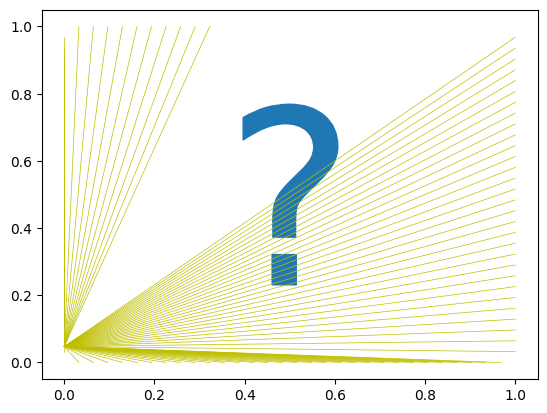

In [4]:
# linear_tomo_example.plot_model(linear_tomo_example.good_model, paths=True);
# linear_tomo_example.plot_model(linear_tomo_example.good_model);
plt.plot(0.5, 0.5, marker="$?$", markersize=130)
for p in linear_tomo_example._paths[:100]:
     plt.plot([p[0],p[2]],[p[1],p[3]],'y',linewidth=0.5)
print(' Data set contains ',len(linear_tomo_example._paths),' ray paths')

### Step 1. Define CoFI `BaseProblem`

Now we:
- set up the BaseProblem in CoFI, 
- supply it the data vector from espresso example, (i.e. the $\mathbf{d}$ vector)
- supply it the Jacobian of the linear system (i.e. the $A$ matrix)

In [5]:
linear_tomo_problem = cofi.BaseProblem()
linear_tomo_problem.set_data(linear_tomo_example.data)
linear_tomo_problem.set_jacobian(linear_tomo_example.jacobian(linear_tomo_example.starting_model)) # supply matrix A
sigma = 0.1 # set noise level of data
data_cov_inv = np.identity(linear_tomo_example.data_size) * (1/sigma**2)
linear_tomo_problem.set_data_covariance_inv(data_cov_inv)

Evaluating paths: 100%|████████████████████████████████████████████████████████████████████| 10416/10416 [00:00<00:00, 15736.25it/s]



Evaluating paths:   9%|████                                         | 951/10416 [00:00<00:00, 9502.10it/s]


Evaluating paths:  19%|████████▏                                   | 1928/10416 [00:00<00:00, 9658.27it/s]


Evaluating paths:  28%|████████████▏                               | 2894/10416 [00:00<00:00, 9588.11it/s]


Evaluating paths:  37%|████████████████▎                           | 3869/10416 [00:00<00:00, 9646.91it/s]


Evaluating paths:  46%|████████████████████▍                       | 4843/10416 [00:00<00:00, 9679.52it/s]


Evaluating paths:  56%|████████████████████████▌                   | 5812/10416 [00:00<00:00, 9668.87it/s]


Evaluating paths:  65%|████████████████████████████▋               | 6795/10416 [00:00<00:00, 9720.42it/s]


Evaluating paths:  75%|████████████████████████████████▊           | 7768/10416 [00:00<00:00, 9650.43it/s]


Evaluating paths:  84%|████████████████████████████████████▉       | 8741/10416 [00:00<00:00, 9671.30it/s]


Evaluating paths:  93%|█████████████████████████████████████████   | 9709/10416 [00:01<00:00, 9673.13it/s]


Evaluating paths: 100%|███████████████████████████████████████████| 10416/10416 [00:01<00:00, 9686.46it/s]

Since $\mathbf{d}$ and $G$ have been defined then this implies a linear system. Now we choose to regularize the linear system and solve the problem 

$$ \min_{\mathbf s} \phi({\mathbf d},{\mathbf s}) = ({\mathbf d} - A {\mathbf s})^T C_d^{-1} ({\mathbf d} - A {\mathbf s})~ + ~ \lambda ~{\mathbf s}D^TD{\mathbf s}$$

The matrix system we are solving is 

$$
(\mathbf{A}^T \textbf{C}_d^{-1} \textbf{A} + \lambda \mathbf D^T\mathbf D) \textbf{s} = \textbf{A}^T \mathbf C_d^{-1} \textbf{d}
$$

In [6]:
# set up regularization
lamda = 0.5   # choose regularization constant
reg_damping = lamda * cofi.utils.QuadraticReg(
    model_shape=(linear_tomo_example.model_size,)
)
linear_tomo_problem.set_regularization(reg_damping)
print('Number of slowness parameters to be solved for = ',linear_tomo_example.model_size)

Number of slowness parameters to be solved for =  2500


and lets print a summary of the set up.

In [7]:
linear_tomo_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: Unknown
---------------------------------------------------------------------
List of functions/properties set by you:
['jacobian', 'regularization', 'data', 'data_covariance_inv']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['jacobian_times_vector']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian_times_vector', 'data_misfit', 'regularization_matrix', 'forward', 'data_covariance', 'initial_model', 'model_shape', 'blobs_dtype', 'bounds', 'constraints']


### Step 2. Define CoFI `InversionOptions`

Here we choose the backend tool for solving the tomographic system, which is scipy's least squares solver.

In [8]:
tomo_options = cofi.InversionOptions()
tomo_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

In [9]:
tomo_inv = cofi.Inversion(linear_tomo_problem, tomo_options)
tomo_inv_result = tomo_inv.run()
tomo_inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
model: [1.13306453 0.86363911 1.01958229 ... 1.01319821 0.8615539  1.14691342]
sum_of_squared_residuals: []
effective_rank: 2500
singular_values: [373.05549274 344.05222637 344.05222637 ...   1.4576611    1.35184016
   1.35184016]
model_covariance: [[ 1.86880217e-01 -9.69914246e-02 -1.15714682e-02 ...  6.47051363e-05
  -2.09495749e-05 -2.00817961e-04]
 [-9.69914246e-02  3.02828183e-01 -6.75690464e-02 ... -4.09130322e-04
   3.44626731e-04 -2.09495749e-05]
 [-1.15714682e-02 -6.75690464e-02  2.21952501e-01 ...  3.27488527e-04
  -4.09130322e-04  6.47051363e-05]
 ...
 [ 6.47051363e-05 -4.09130322e-04  3.27488527e-04 ...  2.21952501e-01
  -6.75690464e-02 -1.15714682e-02]
 [-2.09495749e-05  3.44626731e-04 -4.09130322e-04 ... -6.75690464e-02
   3.02828183e-01 -9.69914246e-02]
 [-2.00817961e-04 -2.09495749e-05  6.47051363e-05 ... -1.15714682e-02
  -9.69914246e-02  1.86880217e-01]]


Lets plot the image to see what we got.

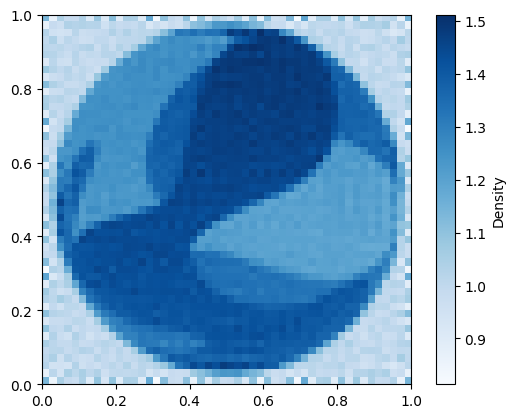

In [10]:
ax = linear_tomo_example.plot_model(tomo_inv_result.model);

### Challenge: Fewer ray paths for linear travel time

Try and construct a tomographic solution with **fewer ray paths**.

Here we use 10416 ray paths with indices 0,10415. Try a different range and see what you get.

How many ray paths do you need before the image becomes recognizable?

[![Upload to Excalidraw_1](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=b321011e797fe6be8b57,DFQFvjtGIvVWBPOUasopIw)


Start from the code template below:

```
# data range
idx_from, idx_to = (<CHANGE ME>, <CHANGE ME>)

# basic settings
d = linear_tomo_example.data
G = linear_tomo_example.jacobian(linear_tomo_example.starting_model)

# now attach all the info to a BaseProblem object
mytomo = cofi.BaseProblem()
mytomo.set_data(d[idx_from:idx_to])
mytomo.set_jacobian(G[idx_from:idx_to,:])

# run your problem (with the same InversionOptions) again
mytomo_inv = cofi.Inversion(mytomo, tomo_options)
mytomo_result = mytomo_inv.run()

# check result
fig = linear_tomo_example.plot_model(mytomo_result.model)
plt.title(f'Recovered model from range ({idx_from}, {idx_to})')
plt.figure()
plt.title(' Raypaths')
for p in linear_tomo_example._paths[idx_from:idx_to]:
    plt.plot([p[0],p[2]],[p[1],p[3]],'y',linewidth=0.05)
```


In [11]:
# Copy the template above, Replace <CHANGE ME> with your answer



Evaluating paths: 100%|████████████████████████████████████████████████████████████████████| 10416/10416 [00:00<00:00, 16255.39it/s]


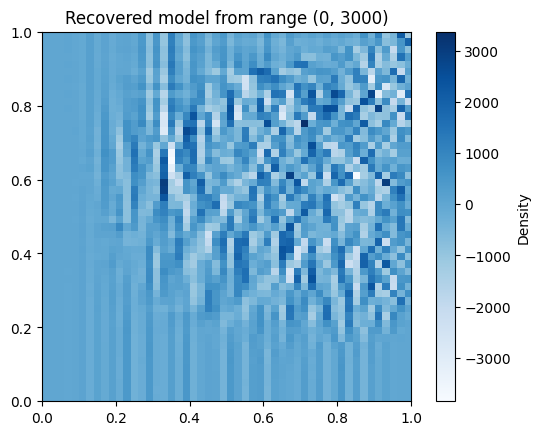

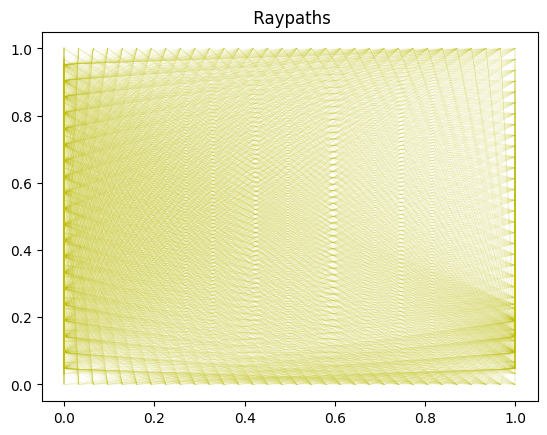


Evaluating paths:  28%|████████████                                | 2866/10416 [00:00<00:00, 9428.64it/s]


Evaluating paths:  37%|████████████████▏                           | 3820/10416 [00:00<00:00, 9470.58it/s]


Evaluating paths:  46%|████████████████████▏                       | 4770/10416 [00:00<00:00, 9479.90it/s]


Evaluating paths:  55%|████████████████████████▏                   | 5719/10416 [00:00<00:00, 9448.96it/s]


Evaluating paths:  64%|████████████████████████████▏               | 6675/10416 [00:00<00:00, 9483.56it/s]


Evaluating paths:  73%|████████████████████████████████▏           | 7624/10416 [00:00<00:00, 9436.03it/s]


Evaluating paths:  82%|████████████████████████████████████▏       | 8573/10416 [00:00<00:00, 9452.00it/s]


Evaluating paths:  91%|████████████████████████████████████████▏   | 9528/10416 [00:01<00:00, 9480.56it/s]


Evaluating paths: 100%|███████████████████████████████████████████| 10416/10416 [00:01<00:00, 9484.62it/s]

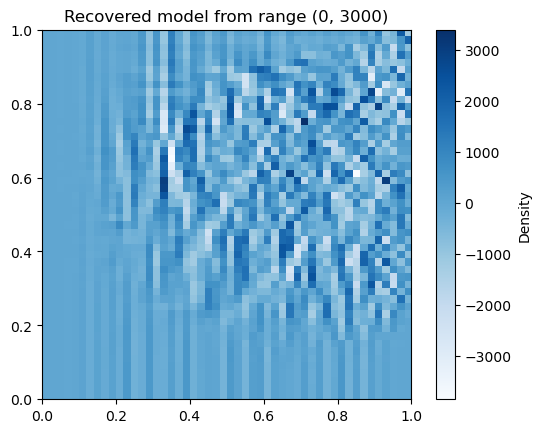

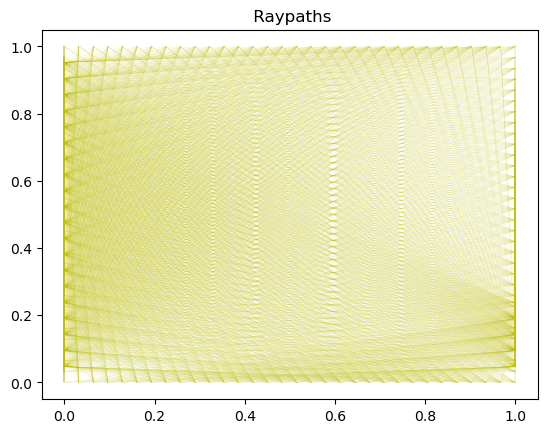

In [12]:
#@title Solution

# data range
idx_from, idx_to = (0, 3000)                    # TODO try a different range

# basic settings
d = linear_tomo_example.data
G = linear_tomo_example.jacobian(linear_tomo_example.starting_model)

# now attach all the info to a BaseProblem object
mytomo = cofi.BaseProblem()
mytomo.set_data(d[idx_from:idx_to])
mytomo.set_jacobian(G[idx_from:idx_to,:])

# run your problem (with the same InversionOptions) again
mytomo_inv = cofi.Inversion(mytomo, tomo_options)
mytomo_result = mytomo_inv.run()

# check result
fig = linear_tomo_example.plot_model(mytomo_result.model)
plt.title(f'Recovered model from range ({idx_from}, {idx_to})')
plt.figure()
plt.title(' Raypaths')
for p in linear_tomo_example._paths[idx_from:idx_to]:
    plt.plot([p[0],p[2]],[p[1],p[3]],'y',linewidth=0.05)

----------

## 2. Non-linear Travel Time Tomography

Now we demonstrate CoFI on a nonlinear iterative tomographic problem in a cross borehole setting.

We use a different tomographic example from espresso. Here we import the example module and plot the reference seismic model.

In [13]:
# Two choices of forward modelling package 
usepyfm2d = True # switch to use either Fast Marching algorithm from pyfm2d (True) package or geo-espresso (False)

nonlinear_tomo_example = espresso.FmmTomography()

 New data set has:
 10  receivers
 10  sources
 100  travel times
 Range of travel times:  0.008911182496368759 0.0153757024856463 
 Mean travel time: 0.01085811731230709


In [14]:
# collect data sources and receivers
read = False
if(read): # read in travel time data instead of using espresso example
    data_base_path = "../../data/fmm_tomography"
    ttdat = np.loadtxt(f"{data_base_path}/ttimes_crossb_nwt_s10_r10.dat")
    sources = np.loadtxt(f"{data_base_path}/sources_crossb_nwt_s10.dat")[:,1:]
    receivers = np.loadtxt(f"{data_base_path}/receivers_crossb_nwt_r10.dat")[:,1:]
    obstimes = ttdat[:,2]
else:
    obstimes = nonlinear_tomo_example.data
    sources = nonlinear_tomo_example.sources
    receivers = nonlinear_tomo_example.receivers

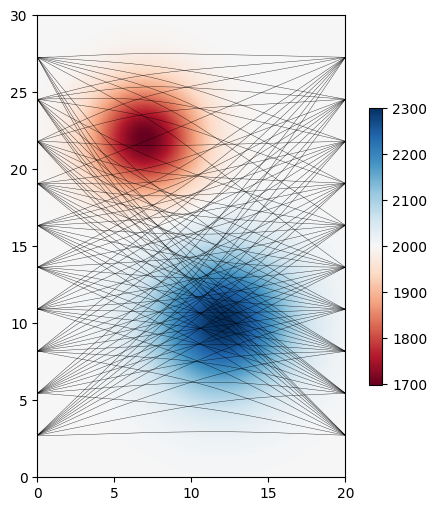

In [15]:
smodel_good = nonlinear_tomo_example.good_model.reshape(nonlinear_tomo_example.model_shape) # retrieve good slowness model
vmodel_good = 1./smodel_good # retrieve good velocity model
if(usepyfm2d):

    # set wavetracker options
    options = wt.WaveTrackerOptions(
        paths=True,
        cartesian=True,
        )

    result = wt.calc_wavefronts(vmodel_good,receivers,sources,extent=nonlinear_tomo_example.extent, options=options) # track wavefronts
    paths = result.paths

    wt.display_model(vmodel_good,paths=paths,extent=nonlinear_tomo_example.extent,line=0.3,alpha=0.82)

else: #Using geo-espresso forward model
    nonlinear_tomo_example.plot_model(sgood_model, with_paths=True,lw=0.5);


### Solving the tomographic system with optimization

Now we solve the tomographic system of equations using either CoFI's optimization method interface, or its iterative matrix-solver interface.

**For the optimization interface:** 

We choose an objective function of the form.

$$\phi(\mathbf{d},\mathbf{s}) = \frac{1}{\sigma^2}|| \mathbf{d} - \mathbf{g}(\mathbf{s})||_2^2 + \lambda_1 ||\mathbf{s}- \mathbf{s}_{0}||_2^2  + \lambda_2 ||D~\mathbf{s}||_2^2$$
   
where $\mathbf{g}(\mathbf{s})$ represents the predicted travel times in the slowness model $\mathbf{s}$, $\sigma^2$ is the noise variance on the travel times, $(\lambda_1,\lambda_2)$ are weights of damping and smoothing regularization terms respectively, $\mathbf{s}_{0}$ is the reference slowness model provided by the espresso example, and $D$ is a second derivative finite difference stencil for the slowness model with shape `model_shape`.

In the set up below this objective function is defined outside of CoFI in the function `objective_func` together with its gradient and Hessian, `gradient` and `hessian`  with respect to slowness parameters. For convenience the regularization terms are constructed with CoFI utility routine `QuadraticReg`. 

For the optimization case CoFI passes `objective_func` and optionally the `gradient` and `Hessian` functions to a thrid party optimization backend tool such as `scipy.minimize` to produce a solution.

**For the iterative matrix solver interface:** 

For convenience, CoFI also has its own Gauss-Newton Solver for optimization of a general objective function of the form.
$$
\phi(\mathbf{d},\mathbf{s}) = \psi((\mathbf{d},\mathbf{s}) + \sum_{r=1}^R \lambda_r \chi_r(\mathbf{s}),
$$
where $\psi$ represents a data misfit term, and $\chi_r$ one or more regularization terms, with weights $\lambda_r$. The objective function above is a special case of this. In general an iterative Gauss-Newton solver takes the form

$$ 
\mathbf{s}_{k+1} = \mathbf{s}_{k} - \cal{H}^{-1}(\mathbf{s}_k) \nabla \phi(\mathbf{s}_k), \quad {(k=0,1,\dots)},
$$

where $\cal{H}(\mathbf{s}_k)$ is the Hessian of the objective function, and $\nabla \phi(\mathbf{s}_k)$ its gradient evaluated at the model $\mathbf{s}_k$.

For the objective function above this becomes the simple iterative matrix solver

$$ \mathbf{s}_{k+1} = \mathbf{s}_k + (A^T C_d^{-1}A + \lambda_2\mathbf{I} +\lambda_2D^TD )^{-1} [A^T C_d^{-1} (\mathbf{d} - g(\mathbf{s}_k)) -  \lambda_2 (\mathbf{s - s}_{0}) - \lambda_2 D^TD \mathbf{s}], \quad (k=0,1,\dots)$$

with $C_d^{-1} = \sigma^{-2} I$.


### Step 1. Define CoFI `BaseProblem`

In [16]:
# get problem information from  espresso FmmTomography
model_size = nonlinear_tomo_example.model_size               # number of model parameters
model_shape = nonlinear_tomo_example.model_shape             # 2D spatial grid shape
data_size = nonlinear_tomo_example.data_size                 # number of data points
ref_start_slowness = nonlinear_tomo_example.starting_model   # use the starting guess supplied by the espresso example
extent = nonlinear_tomo_example.extent

Here we define the baseproblem object and a starting velocity model guess.

In [17]:
# define CoFI BaseProblem
nonlinear_problem = cofi.BaseProblem()
nonlinear_problem.set_initial_model(ref_start_slowness)

Here we define regularization of the tomographic system.

In [18]:
# add regularization: damping / flattening / smoothing
damping_factor = 50
smoothing_factor = 5e3
reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape, 
    weighting_matrix="damping", 
    reference_model=ref_start_slowness
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
reg = reg_damping + reg_smoothing

In [19]:
# add regularization: flattening + smoothing
smoothing_factor = 5e6
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
reg = reg_smoothing

In [20]:
def objective_func(slowness, reg, sigma, data_subset=None):
    if data_subset is None: 
        data_subset = np.arange(0, nonlinear_tomo_example.data_size)
    if(usepyfm2d):
        options = wt.WaveTrackerOptions(
            cartesian=True,
            )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options) # track wavefronts
        ttimes = result.ttimes
    else:
        ttimes = nonlinear_tomo_example.forward(slowness)
    residual = obstimes[data_subset] - ttimes[data_subset]
    data_misfit = residual.T @ residual / sigma**2
    model_reg = reg(slowness)
    return  data_misfit + model_reg

def gradient(slowness, reg, sigma, data_subset=None):
    if data_subset is None: 
        data_subset = np.arange(0, nonlinear_tomo_example.data_size)
    if(usepyfm2d):
        options = wt.WaveTrackerOptions(
                    paths=True,
                    frechet=True,
                    cartesian=True,
                    )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options) # track wavefronts
        ttimes = result.ttimes
        A = result.frechet.toarray()
    else:
        ttimes, A = nonlinear_tomo_example.forward(slowness, return_jacobian=True) # use geo-espresso forward model
    ttimes = ttimes[data_subset]
    A = A[data_subset]
    data_misfit_grad = -2 * A.T @ (obstimes[data_subset] - ttimes) / sigma**2
    model_reg_grad = reg.gradient(slowness)
    return  data_misfit_grad + model_reg_grad

def hessian(slowness, reg, sigma, data_subset=None):
    if data_subset is None: 
        data_subset = np.arange(0, nonlinear_tomo_example.data_size)
    if(usepyfm2d):
        options = wt.WaveTrackerOptions(
                    paths=True,
                    frechet=True,
                    cartesian=True,
                    )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options)
        ttimes = result.ttimes
        A = result.frechet.toarray()
    else:
        A = nonlinear_tomo_example.jacobian(slowness) # use geo-espresso forward model 
    A = A[data_subset]
    data_misfit_hess = 2 * A.T @ A / sigma**2 
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

In [21]:
sigma = 0.00001                   # Noise is 1.0E-4 is ~5% of standard deviation of initial travel time residuals
sigma = 0.000008
nonlinear_problem.set_objective(objective_func, args=[reg, sigma, None])
nonlinear_problem.set_gradient(gradient, args=[reg, sigma, None])
nonlinear_problem.set_hessian(hessian, args=[reg, sigma, None])

### Step 2. Define CoFI `InversionOptions`

In [22]:
nonlinear_options = cofi.InversionOptions()

# cofi's own simple newton's matrix-based optimization solver
nonlinear_options.set_tool("cofi.simple_newton")
nonlinear_options.set_params(num_iterations=15, step_length=1, obj_tol=1e-16, verbose=True, hessian_is_symmetric=True)

# scipy's Newton-CG solver (alternative approach with similar results)
# nonlinear_options.set_tool("scipy.optimize.minimize")
# nonlinear_options.set_params(method="Newton-CG", options={"xtol":1e-16})

### Step 3. Define CoFI `Inversion` and run

Iteration #0, updated objective function value: 10590.591742696766
Iteration #1, updated objective function value: 1016.707316434764
Iteration #2, updated objective function value: 352.6949412329181
Iteration #3, updated objective function value: 194.27796655731808
Iteration #4, updated objective function value: 198.93877273390277
Iteration #5, updated objective function value: 75.88732477358602
Iteration #6, updated objective function value: 81.8288391981705
Iteration #7, updated objective function value: 62.163270745719146
Iteration #8, updated objective function value: 53.01030545860854
Iteration #9, updated objective function value: 51.23567248301646
Iteration #10, updated objective function value: 32.820593461370734
Iteration #11, updated objective function value: 30.513658760382885
Iteration #12, updated objective function value: 23.52156487302416
Iteration #13, updated objective function value: 29.28391991686121
Iteration #14, updated objective function value: 19.28524643105309


Iteration #2, updated objective function value: 5.825780480486444


Iteration #3, updated objective function value: 3.671788666778372


Iteration #4, updated objective function value: 1.607554713000219


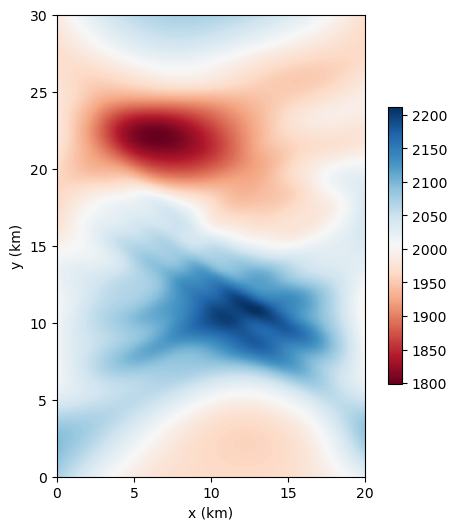

In [23]:
nonlinear_inv = cofi.Inversion(nonlinear_problem, nonlinear_options)
nonlinear_inv_result = nonlinear_inv.run()
nonlinear_inv_result.summary()


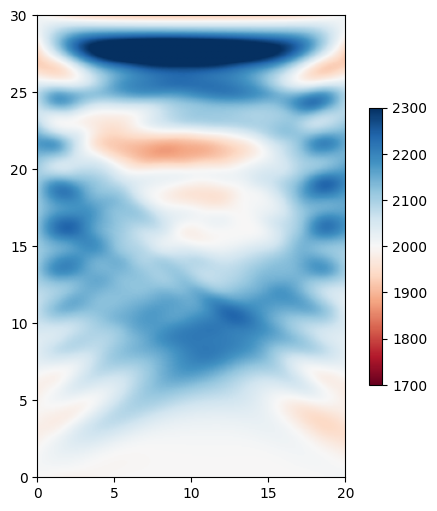

In [24]:
#nonlinear_tomo_example.plot_model(nonlinear_inv_result.model);
vmodel_inverted = 1./nonlinear_inv_result.model.reshape(model_shape)
wt.display_model(vmodel_inverted,extent=extent,clim=[1700,2300]) # inverted model

Now lets plot the true model for comparison.

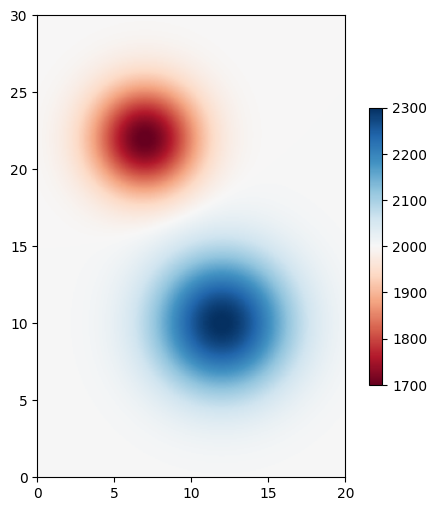

In [25]:
#nonlinear_tomo_example.plot_model(smodel_good);
wt.display_model(vmodel_good,extent=extent,clim=[1700,2300]) # true model

### Challenge: Change the number of tomographic data

First try and repeat this tomographic reconstruction with fewer data and see what the model looks like.

There are 100 raypaths in the full dataset and you can tell CoFI to select a subset by passing an additional
array of indices to the functions that calculate objective, gradient and hessian.

[![Upload to Excalidraw_1](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=e7b2daaee98391d80287,lDK6zdAlW_fMfLSe_UVd3Q)



Start from the code template below:

```
# Set a subset of raypaths here
data_subset = np.arange(<CHANGE ME>)

# select BaseProblem
my_own_nonlinear_problem = cofi.BaseProblem()
my_own_nonlinear_problem.set_objective(objective_func, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_gradient(gradient, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_hessian(hessian, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_initial_model(ref_start_slowness)

# run inversion with same options as previously
my_own_inversion = cofi.Inversion(my_own_nonlinear_problem, nonlinear_options)
my_own_result = my_own_inversion.run()

# check results
my_own_result.summary()

# plot inverted model
fig, paths = nonlinear_tomo_example.plot_model(my_own_result.model, return_paths=True)
print(f"Number of paths used: {len(data_subset)}")

# plot paths used
for p in np.array(paths, dtype=object)[data_subset]:
    fig.axes[0].plot(p[:,0], p[:,1], "g", alpha=0.5,lw=0.5)
```

In [26]:
# Copy the template above, Replace <CHANGE ME> with your answer



Iteration #0, updated objective function value: 260.31725482231406
Iteration #1, updated objective function value: 7.258902674641346
Iteration #2, updated objective function value: 0.31917874336601487
Iteration #3, updated objective function value: 0.1725958010846405
Iteration #4, updated objective function value: 0.09427521137239286
Iteration #5, updated objective function value: 0.16228933907173831
Iteration #6, updated objective function value: 0.034756872771923006
Iteration #7, updated objective function value: 0.036117261257296335
Iteration #8, updated objective function value: 0.020607086939947863
Iteration #9, updated objective function value: 0.02064271122386619
Iteration #10, updated objective function value: 0.01592477423784836
Iteration #11, updated objective function value: 0.015283694808034397
Change in model parameters below tolerance, stopping.
Summary for inversion result
SUCCESS
----------------------------
model: [0.00050002 0.00050002 0.0005     ... 0.00050281 0.0005

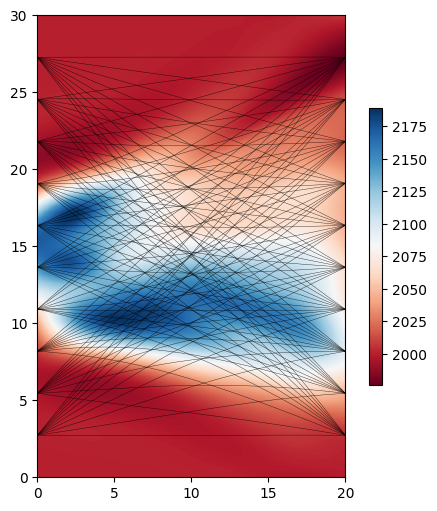

Number of paths used: 30


Iteration #2, updated objective function value: 0.4155731243675164


Iteration #3, updated objective function value: 0.0044721955346204685


Iteration #4, updated objective function value: 0.0004912544688082658
Change in model parameters below tolerance, stopping.
Summary for inversion result
SUCCESS
----------------------------
model: [0.00050057 0.00050052 0.00050046 ... 0.00051289 0.00051088 0.00050873]
num_iterations: 4
objective_val: 0.0004912544688082658
n_obj_evaluations: 6
n_grad_evaluations: 5
n_hess_evaluations: 5


Number of paths used: 30


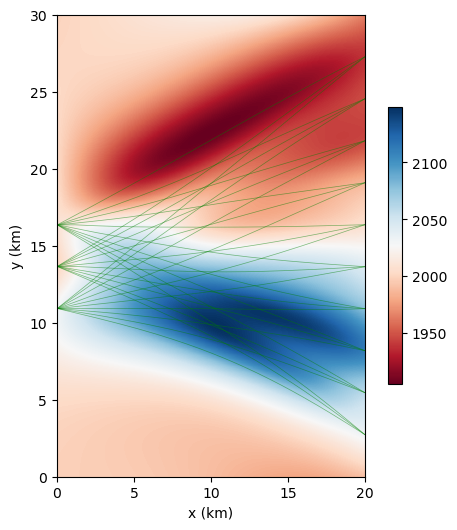

In [27]:
#@title Solution

# Set a subset of raypaths here
data_subset = np.arange(30, 60)

# select BaseProblem
my_own_nonlinear_problem = cofi.BaseProblem()
my_own_nonlinear_problem.set_objective(objective_func, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_gradient(gradient, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_hessian(hessian, args=[reg, sigma, data_subset])
my_own_nonlinear_problem.set_initial_model(ref_start_slowness)

# run inversion with same options as previously
my_own_inversion = cofi.Inversion(my_own_nonlinear_problem, nonlinear_options)
my_own_result = my_own_inversion.run()

# check results
my_own_result.summary()

if(usepyfm2d):

    # set wavetracker options
    options = wt.WaveTrackerOptions(
        paths=True,
        cartesian=True,
        )

    vmodel_inverted = 1./my_own_result.model.reshape(model_shape)
    result = wt.calc_wavefronts(vmodel_inverted,receivers,sources,extent=extent, options=options) # track wavefronts
    paths = result.paths

    wt.display_model(vmodel_inverted,paths=paths,extent=extent,line=0.3,alpha=0.82)

else: #Using geo-espresso forward model
    
    fig, paths = nonlinear_tomo_example.plot_model(my_own_result.model, with_paths=True,lw=0.5); # plot inverted model
    # plot paths used
    for p in np.array(paths, dtype=object)[data_subset]:
        fig.axes.plot(p[:,0], p[:,1], "g", alpha=0.5,lw=0.5)
print(f"Number of paths used: {len(data_subset)}")



### Challenge: Change regularization settings

In the solution above we used `damping_factor = 50`, and `smoothing_factor = 5.0E-3` and `flattening_factor = 0`.

Experiment with these choices, e.g increasing all of them to say 100 and repeat the tomographic solution to see how the model changes.

Try to turn off smoothing all together but retain damping and flattening and see what happens.

With some choices you can force an under-determined problem which is not solvable.

(Note that here we revert back to using all of the data by removing the `data_subset` argument to the objective function.)

To repeat this solver with other settings for smoothing and damping strength. See the documentation for [cofi.utils.QuadraticReg](https://cofi.readthedocs.io/en/latest/api/generated/cofi.utils.QuadraticReg.html).


[![Upload to Excalidraw_1](https://img.shields.io/badge/Click%20&%20upload%20your%20results%20to-Excalidraw-lightgrey?logo=jamboard&style=for-the-badge&color=fcbf49&labelColor=edede9)](https://excalidraw.com/#room=ef734afd2c74f472ec59,fy81-1Fm-pAgQmHdtboG7w)



You can start from the template below:

```
# change the combination of damping, flattening and smoothing regularizations
damping_factor = <CHANGE ME>                # select damping factor here to force solution toward reference slowness model 
flattening_factor = <CHANGE ME>             # increase flattening factor here to force small first derivatives in slowness solution
smoothing_factor = <CHANGE ME>              # increase smoothing factor here to force small second derivatives in slowness solution

reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="damping",
    reference_model=ref_start_slowness
)
reg_flattening = flattening_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="flattening"
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
my_own_reg = reg_damping + reg_flattening + reg_smoothing

# set Baseproblem
my_own_nonlinear_problem = cofi.BaseProblem()
my_own_nonlinear_problem.set_objective(objective_func, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_gradient(gradient, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_hessian(hessian, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_initial_model(ref_start_slowness.copy())

# run inversion with same options as previously
my_own_inversion = cofi.Inversion(my_own_nonlinear_problem, nonlinear_options)
my_own_result = my_own_inversion.run()

# check results
fig = nonlinear_tomo_example.plot_model(my_own_result.model)
fig.suptitle(f"Damping {damping_factor}, Flattening {flattening_factor}, Smoothing {smoothing_factor}");
```

In [28]:
# Copy the template above, Replace <CHANGE ME> with your answer



Iteration #0, updated objective function value: 10585.861837637176
Iteration #1, updated objective function value: 595.6540893502723
Iteration #2, updated objective function value: 56.4799079533638
Iteration #3, updated objective function value: 1.3257479631759217
Iteration #4, updated objective function value: 0.0005078407617091778
Change in model parameters below tolerance, stopping.


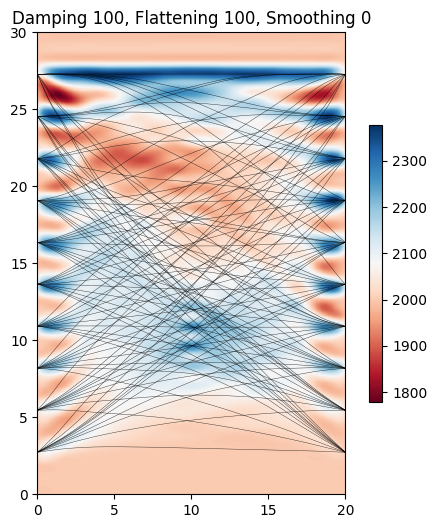

Iteration #2, updated objective function value: 710.1208786960945


Iteration #3, updated objective function value: 715.5022745101638


Iteration #4, updated objective function value: 685.5111622410774


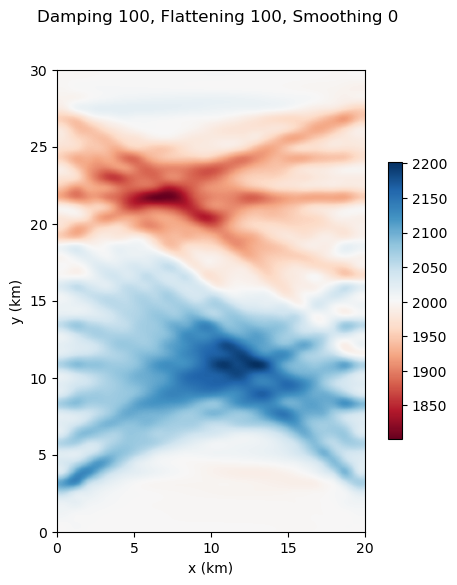

In [29]:
#@title Reference Solution

# change the combination of damping, flattening and smoothing regularizations
damping_factor = 100                # select damping factor here to force solution toward reference slowness model 
flattening_factor = 100             # increase flattening factor here to force small first derivatives in slowness solution
smoothing_factor = 0                # increase smoothing factor here to force small second derivatives in slowness solution

reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="damping",
    reference_model=ref_start_slowness
)
reg_flattening = flattening_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="flattening"
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
my_own_reg = reg_damping + reg_flattening + reg_smoothing

# set Baseproblem
my_own_nonlinear_problem = cofi.BaseProblem()
my_own_nonlinear_problem.set_objective(objective_func, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_gradient(gradient, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_hessian(hessian, args=[my_own_reg, sigma, None])
my_own_nonlinear_problem.set_initial_model(ref_start_slowness.copy())

# run inversion with same options as previously
my_own_inversion = cofi.Inversion(my_own_nonlinear_problem, nonlinear_options)
my_own_result = my_own_inversion.run()

# check results
if(usepyfm2d):

    # set wavetracker options
    options = wt.WaveTrackerOptions(
        paths=True,
        cartesian=True,
        )

    vmodel_inverted = 1./my_own_result.model.reshape(model_shape)
    result = wt.calc_wavefronts(vmodel_inverted,receivers,sources,extent=extent, options=options) # track wavefronts
    paths = result.paths

    title = f"Damping {damping_factor}, Flattening {flattening_factor}, Smoothing {smoothing_factor}"
    wt.display_model(vmodel_inverted,paths=paths,extent=extent,line=0.3,alpha=0.82,title=title)

else: #Using geo-espresso forward model
    
    ax = nonlinear_tomo_example.plot_model(my_own_result.model, with_paths=True,lw=0.5); # plot inverted model
    ax.get_figure().suptitle(f"Damping {damping_factor}, Flattening {flattening_factor}, Smoothing {smoothing_factor}");

---

## Watermark

In [30]:
watermark_list = ["cofi", "espresso", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10+24.gf41e747
espresso 0.3.19
numpy 2.1.3
scipy 1.14.1
matplotlib 3.10.1
